In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [68]:
matplotlib.rcParams.update({'font.size': 16})

# Problem 1 - Newman 10.9

## part (a)

In [3]:
def energy(spins, J=1):
    N = spins.shape[0]
    M = spins.shape[1]
    left_shift = np.hstack([spins[:, 1:], np.zeros((N, 1))])
    up_shift = np.vstack([spins[1:, :], np.zeros((1, M))])
    return (left_shift*spins + up_shift*spins).sum() * -J

In [4]:
spins = np.ones((20,20))

In [5]:
energy(spins)

-760.0

## part (b)

In [6]:
def MetroSim(N, spins, J=1, T=1):
    M = [spins.sum()]
    II, JJ = spins.shape
    E1 = energy(spins, J=J)
    for k in range(N):
        i = np.random.randint(0, II)
        j = np.random.randint(0, JJ)
        spins[i,j] *= -1
        E2 = energy(spins, J=J)
        
        if np.random.random() < np.exp(-(E2 - E1)/T):
            # Accept
            E1 = E2
        else:
            # Reject
            spins[i,j] *= -1
        M.append(spins.sum())
    return M

In [54]:
# Set the spins randomly
spins = np.random.random((20,20))
spins[spins > 0.5] = 1
spins[spins <= 0.5] = -1
energy(spins)

-8.0

In [55]:
magns = MetroSim(int(1e6), spins, T=3)

In [44]:
running_total = 0
for _ in range(50):
    spins = np.random.random((20,20))
    spins[spins > 0.5] = 1
    spins[spins <= 0.5] = -1
    magns = MetroSim(int(5e5), spins)
    running_total += np.sign(magns[-1])
running_total / 50

-0.04

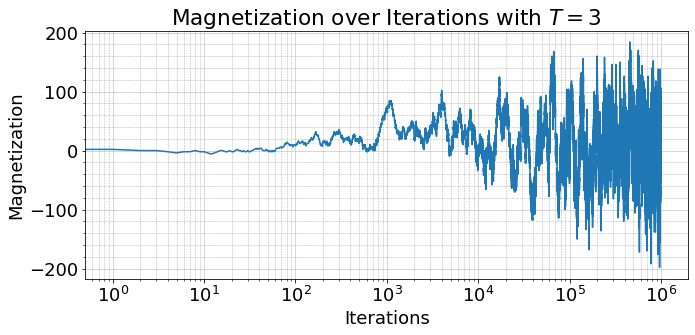

In [56]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_size_inches(10,5)

ax.plot(magns)
ax.set_xlabel("Iterations")
ax.set_ylabel("Magnetization")
ax.set_title("Magnetization over Iterations with $T=3$")
ax.set_xscale('log')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()

# Problem 2 - Newman 10.11

In [21]:
def dimer_energy(lattice):
    return -(lattice != 0).sum() # No need to divide by two since equivalent solutions

In [22]:
def make_entry(i1, j1, i2, j2):
    return int(i1*pow(10, 3*2) + j1*pow(10, 2*2) + i2*pow(10, 1*2) + j2*pow(10, 0*2))

In [23]:
def parse_entry(num):
    i1 = int(num // pow(10, 3*2))
    num -= i1*pow(10, 3*2)
    
    j1 = int(num // pow(10, 2*2))
    num -= j1*pow(10, 2*2)
    
    i2 = int(num // pow(10, 1*2))
    num -= i2*pow(10, 1*2)
    
    j2 = int(num)
    return (i1, j1, i2, j2)

In [24]:
def get_random_neighbor(lattice, i, j):
    # Neighbors: list[Up, Down, Left, Right]
    neighbors = [False, False, False, False]
    results = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    II, JJ = lattice.shape
    if i + 1 >= II:
        neighbors[1] = True
    if i - 1 < 0:
        neighbors[0] = True
    if j + 1 >= JJ:
        neighbors[3] = True
    if j - 1 < 0:
        neighbors[2] = True
    
    neighbors = np.array(neighbors)
    num_empties = 4 - neighbors.sum()
    if num_empties == 0:
        return None
    empties = np.argwhere(~neighbors).flatten()
    randnum = np.random.randint(0, num_empties)
    return results[empties[randnum]]

In [81]:
def SimAnnealing(lattice, T0=1, tau=int(1e4), num_steps=int(1e6)):
    II, JJ = lattice.shape
    results = []
    energies = []
    for t in range(num_steps):
        T = T0*np.exp(-t/tau)
        i1 = np.random.randint(0, II)
        j1 = np.random.randint(0, JJ)
        
        if lattice[i1, j1] == 0: # empty spot
            index2 = get_random_neighbor(lattice, i1, j1)
            if index2 is None: continue
            else: i2, j2 = index2
            entry = make_entry(i1, j1, i2, j2)
            lattice[i1, j1] = entry
            lattice[i2, j2] = entry
        elif lattice[i1, j1] != 0: # somebody's here
            if np.random.random() < np.exp(-1/T):
                # Remove
                i1, j1, i2, j2 = parse_entry(lattice[i1, j1])
                lattice[i1, j1] = 0
                lattice[i2, j2] = 0
        else: #incongruent neighbors, do nothing
            continue
        
        energies.append(dimer_energy(lattice))
            
        if (t % 10000) == 0:
            results.append(lattice.copy())
    return results, energies

In [82]:
results, energies = SimAnnealing(np.zeros((50,50)), T0=int(1e5), num_steps=int(2e5))

In [86]:
_, energies2 = SimAnnealing(np.zeros((50,50)), T0=int(1e5), num_steps=int(2e5), tau=int(1e5))

In [84]:
_, energies3 = SimAnnealing(np.zeros((50,50)), T0=int(1e5), num_steps=int(2e5), tau=int(1e3))

In [85]:
_, energies4 = SimAnnealing(np.zeros((50,50)), T0=int(1e5), num_steps=int(2e5), tau=int(1e2))

/home/data1/mdd424/.conda/envs/CompPhysics/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/home/data1/mdd424/.conda/envs/CompPhysics/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


In [95]:
_, energies5 = SimAnnealing(np.zeros((50,50)), T0=int(1e5), num_steps=int(2e5), tau=10)

/home/data1/mdd424/.conda/envs/CompPhysics/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/home/data1/mdd424/.conda/envs/CompPhysics/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


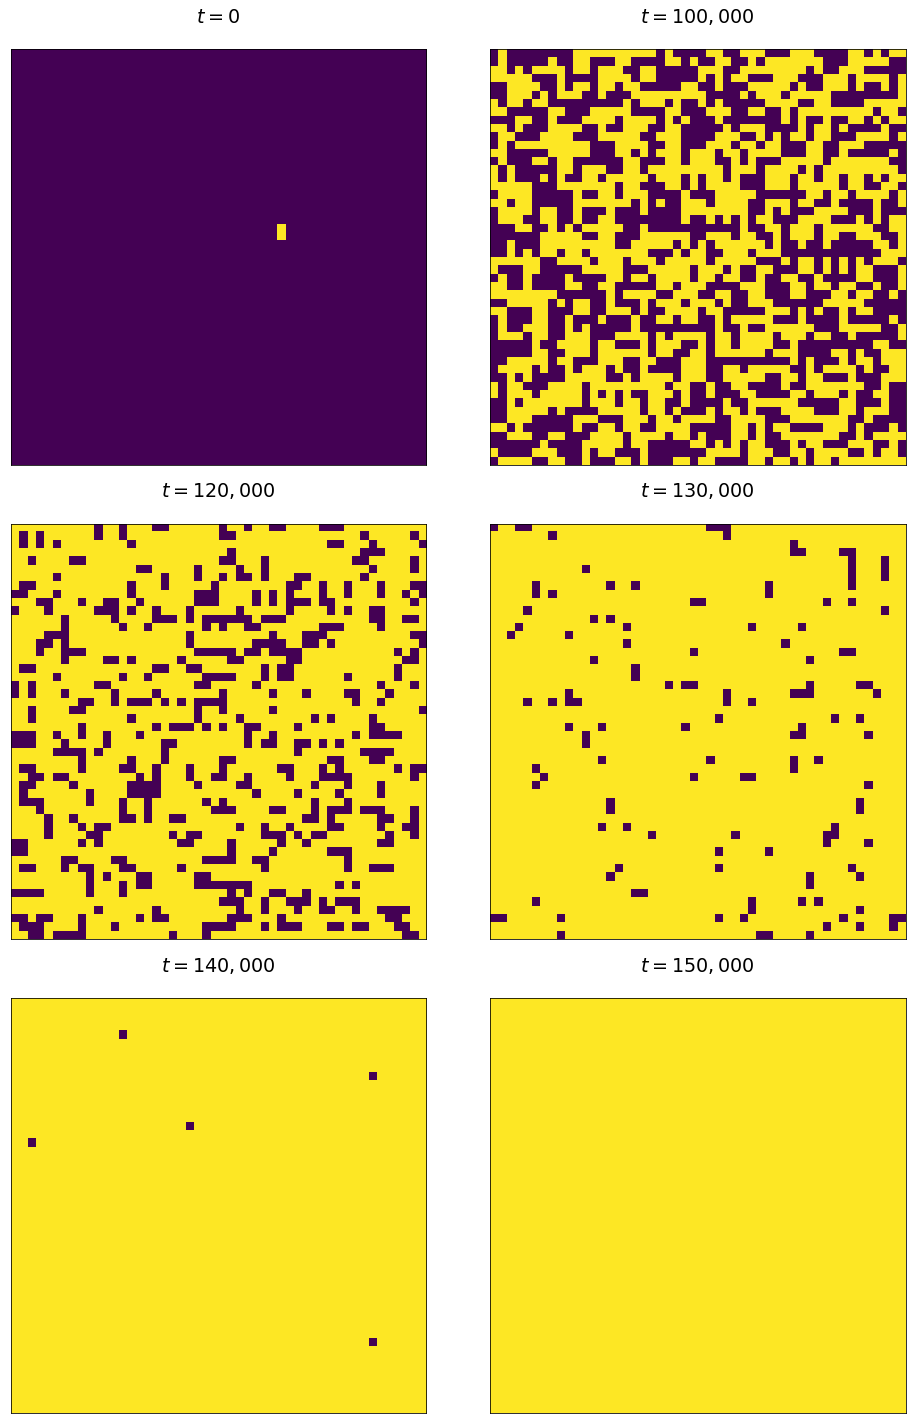

In [80]:
fig = plt.figure()
fig.set_size_inches(14,20)

ax = fig.add_subplot(321)
ax.set_title("$t=0$")
ax.matshow((results[0] != 0))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = fig.add_subplot(322)
ax.set_title("$t=100,000$")
ax.matshow((results[10] != 0))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = fig.add_subplot(323)
ax.set_title("$t=120,000$")
ax.matshow((results[12] != 0))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = fig.add_subplot(324)
ax.set_title("$t=130,000$")
ax.matshow((results[13] != 0))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = fig.add_subplot(325)
ax.set_title("$t=140,000$")
ax.matshow((results[14] != 0))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = fig.add_subplot(326)
ax.set_title("$t=150,000$")
ax.matshow((results[16] != 0), cmap="viridis_r")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

fig.tight_layout()
fig.savefig("dimers.png")

/home/data1/mdd424/.conda/envs/CompPhysics/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


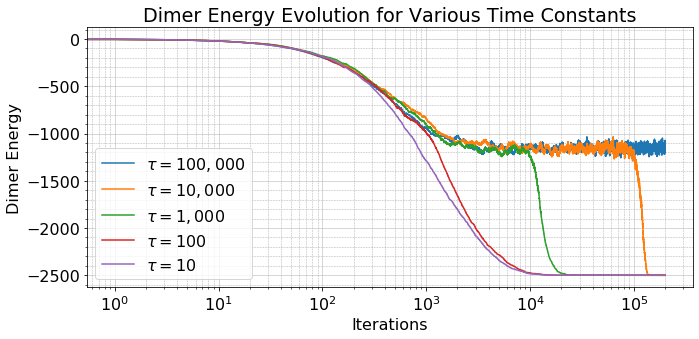

In [96]:
fig = plt.figure()
fig.set_size_inches(10,5)
ax = fig.add_subplot()

N = int(2e5)
ax.plot(range(N), energies2, label=r"$\tau = 100,000$")
ax.plot(range(N), energies, label=r"$\tau = 10,000$")
ax.plot(range(N), energies3, label=r"$\tau = 1,000$")
ax.plot(range(N), energies4, label=r"$\tau = 100$")
ax.plot(range(N), energies5, label=r"$\tau = 10$")
ax.set_xlabel("Iterations")
ax.set_ylabel("Dimer Energy")
ax.set_title("Dimer Energy Evolution for Various Time Constants")
ax.set_xscale('log')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()
ax.legend();
fig.savefig("dimer_time_constants.png")

# Problem 3

## part (a)

In [97]:
def lcg(N=None, seed=None):
    a = 1664525
    c = 1013904223
    m = 4294967296
    if seed is None:
        seed = int(time.time()*1000)
        
    if type(N) is not int:
        return ((a*seed + c) % m) / m
    else:
        results = []
        for _ in range(N):
            seed = (a*seed + c) % m
            results.append(seed/m)
        return np.array(results)

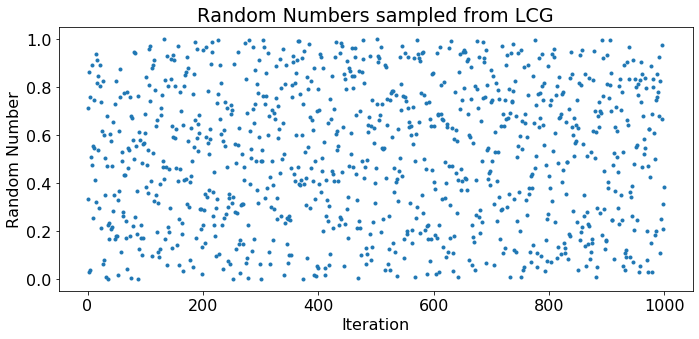

In [101]:
fig = plt.figure()
fig.set_size_inches(10, 5)
ax = fig.add_subplot()

ax.plot(range(1000), lcg(N=1000), '.')
ax.set_title("Random Numbers sampled from LCG")
ax.set_xlabel("Iteration")
ax.set_ylabel("Random Number")
fig.tight_layout()
fig.savefig("random_nums.pnggaussian_sample(1, N=int(1e5))")

## part (b)

### Gaussian Random Variable
$$ \theta \sim \text{Unif}(0, 2\pi)$$
and
$$ r \sim p(r) = \frac{r}{\sigma^2}\exp\left(-\frac{r^2}{2\sigma^2}\right) $$
with quantile function
$$ Q_r(z) = \sqrt{-2\sigma^2\ln(1-z)} $$
Therefore, we can sample from a Gaussian as follows

In [102]:
def gaussian_sample(sigma, N=None, seed=None):
    Q = lambda z: np.sqrt(-2*sigma**2*np.log(1-z))
    if seed is None:
        seed = int(time.time()*1000)
    seed2 = (1103515245*seed + 12345) % 2147483648 # LCG params from glibc
    theta = lcg(N=N, seed=seed)*2*np.pi
    z = lcg(N=N, seed=seed2)
    r = Q(z)
    return r*np.cos(theta)

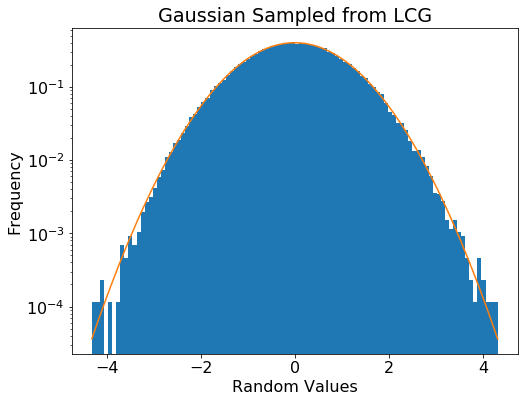

In [114]:
fig = plt.figure()
fig.set_size_inches(8,6)
ax = fig.add_subplot()

sample = gaussian_sample(1, N=int(1e5))
f = lambda x: np.exp(-x**2/2) / np.sqrt(2*np.pi)
xspace = np.linspace(sample.min(),sample.max(), 1000)
ax.hist(sample, bins=100, density=True);
ax.plot(xspace, f(xspace));
ax.set_yscale("log")
ax.set_title("Gaussian Sampled from LCG")
ax.set_xlabel("Random Values")
ax.set_ylabel("Frequency");
fig.savefig("gaussian.png")

## part (c)

### from homework 3

In [115]:
def c_k(data, k):
    N = data.shape[0]
    n = np.arange(0, N)
    return (data*np.exp(-1j*2*np.pi*k*n / N)).sum()

In [122]:
coeffs = np.array([c_k(sample, k) for k in range(5001)][1:])

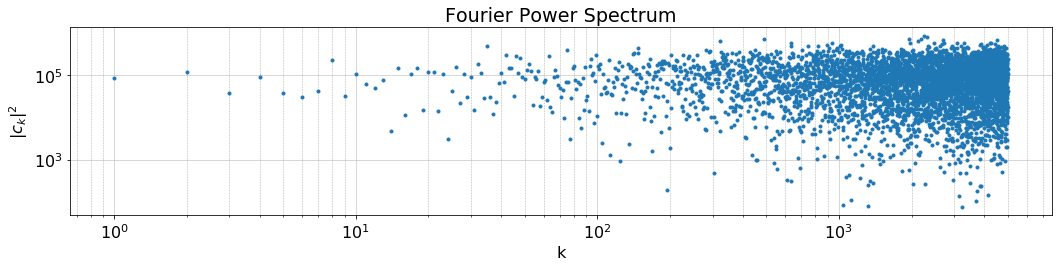

In [127]:
fig = plt.figure()
fig.set_size_inches(15,4)
ax = fig.add_subplot()
ax.plot(np.arange(coeffs.shape[0])+1, (coeffs*coeffs.conjugate()).real, '.')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("k")
ax.set_ylabel("$|c_k|^2$")
ax.set_title("Fourier Power Spectrum")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()

## part (d)

### Do a random walk using the Gaussian sample starting at zero 

In [131]:
walk_vals = [0]
for rvar in sample:
    walk_vals.append(walk_vals[-1] + rvar)
walk_vals = np.array(walk_vals)

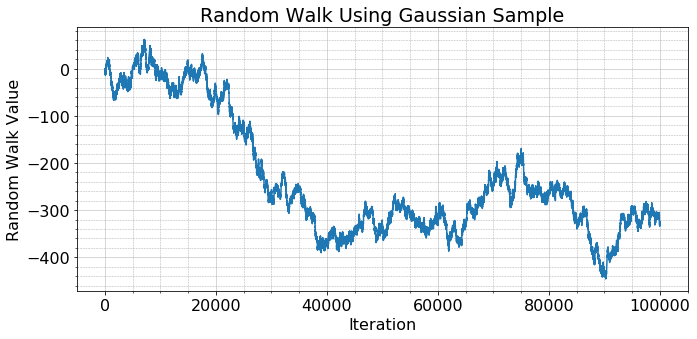

In [162]:
fig = plt.figure()
fig.set_size_inches(10, 5)
ax = fig.add_subplot()

ax.plot(walk_vals)
ax.set_xlabel("Iteration")
ax.set_ylabel("Random Walk Value")
ax.set_title("Random Walk Using Gaussian Sample")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()

## part (e)

In [133]:
walk_coeffs = np.array([c_k(walk_vals, k) for k in range(5001)][1:])

In [153]:
c_k2 = (walk_coeffs*walk_coeffs.conjugate()).real
m,b = np.polyfit(np.log(np.arange(5000)+1), np.log(c_k2), 1)
fit = lambda k: np.exp(m*np.log(k) + b)
m, b

(-1.9967807172181529, 31.07833421015201)

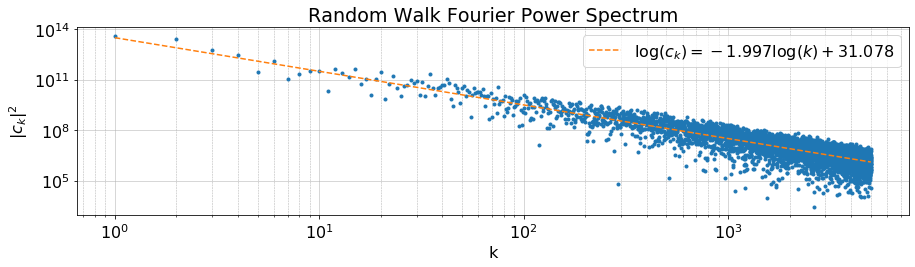

In [165]:
fig = plt.figure()
fig.set_size_inches(13,4)
ax = fig.add_subplot()
ax.plot(np.arange(walk_coeffs.shape[0])+1, (walk_coeffs*walk_coeffs.conjugate()).real, '.')
ax.plot(np.arange(5000)+1, fit(np.arange(5000)+1), '--', label="$\log(c_k) = {:.3f}\log(k) + {:.3f}$".format(m,b))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("k")
ax.set_ylabel("$|c_k|^2$")
ax.set_title("Random Walk Fourier Power Spectrum")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()
fig.tight_layout()